In [1]:
import sys
sys.path.append('../')
import atlas

import os
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# Solar Model with ATLAS

This is the simplest use case for `BasicATLAS` that calculates the structure and emergent spectrum for an atmosphere of a Sun-like star ($T_\mathrm{eff}=5770\ \mathrm{K}$, $\log(g)=4.44$, [standard solar abundances](http://atmos.ucsd.edu?p=solar)).

We will use `~/ATLAS_sun_model` as our working directory. First, make sure the folder does not already exist; and if it does, **remove it**.

In [2]:
rm -rf ~/ATLAS_sun_model

## Structure

The structure (i.e. variation of physical parameters such as *pressure* and *temperature* with *depth*) must be calculated first using `ATLAS-9` which is dispatched with `atlas.atlas()`. In the absence of arguments, the routine will default to solar parameters listed above as well as a set of solar opacity distribution functions provided in `data/solar_ODF`.

In [3]:
run_dir = os.path.expanduser('~/ATLAS_sun_model')
atlas.atlas(run_dir)

Automatically chosen restart: /home/roman/CoolStar/BasicATLAS/restarts/m0t6000g4.0.dat
Launcher created
Starting automatic iterations...
15 iterations completed: max[abs(err)] = 0.427 | max[abs(de)] = 21.022
30 iterations completed: max[abs(err)] = 0.286 | max[abs(de)] = 3.545
ATLAS-9 halted
ATLAS requested/received validation for /home/roman/ATLAS_sun_model successful

Final convergence: max[abs(err)] = 0.286 | max[abs(de)] = 3.545
Saved the model in model.dat
Finished running ATLAS-9 in 0:01:05.243949 s


The structure is calculated by first adopting an initial guess for the temperature profile. Equations of stellar structure (e.g. hydrostatic equilibrium, equation of state etc) are then solved numerically to obtain other physical parameters throughout the atmosphere for both gas and radiation. Since the temperature profile was guessed, the solution is likely incorrect which will manifest itself in *flux errors* and *flux derivative errors*. A flux error (`err` in the output above) is a percentage deviation of the total energy flux (including both convection and radiation) through a layer of structure from the required value parameterized by the provided effective temperature of the star. A flux derivative error (`de` in the output above) is the change in the energy flux across a layer as a percentage of the flux required within that layer by the condition of energy equilibrium.

The aforementioned errors are calculated and used to apply *temperature corrections*, i.e. small adjustments to the initially guessed temperature profile that are expected to reduce those errors. The process is then repeated iteratively until the errors become sufficiently small and the model is said to have *converged*.

`BasicATLAS` carries out temperature correction iterations in batches of $15$ until either the errors become sufficiently small or they stop improving. In this case, 30 iterations were necessary to bring the maximum flux error to $0.286\%$ and the flux derivative error to $3.545\%$ upon which the calculation was terminated. The optional argument `niter` may be passed to `atlas.atlas()` to fix the number of iterations to a constant value instead, irrespective of the calculated errors.

We can now plot the calculated temperature/pressure profile with `MatPlotLib`:

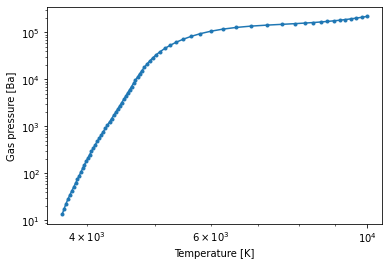

In [4]:
# Load the structure data from the model
structure, units = atlas.read_structure(run_dir)

# Produce a labelled MatPlotLib plot
plt.plot(structure['temperature'], structure['gas_pressure'], '.-')
plt.xlabel('Temperature [K]')
plt.ylabel('Gas pressure [Ba]')
plt.yscale('log')
plt.xscale('log')

Individual points in the plot above represent the layers in the stratification of the model. Typically, `ATLAS-9` uses 72 individual layers. More information on other physical properties available in the structure output as well as units can be found in the dedicated tutorial notebook, `output.ipynb`.

## Spectral Synthesis

The emergent spectrum corresponding to the structure calculated above is synthesized with a satellite utility called `SYNTHE`. `SYNTHE` is dispatched in the cell below between the wavelengths of $100$ nm and $3000$ nm. By default, the calculation is carried out at the resolution of $\lambda/\Delta\lambda=6\times10^{5}$. Lower resolutions may produce less accurate results and, as such, it is recommended to use a higher-than-necessary resolution in calculation and bin the output after the fact if necessary.

***The calculation may take a few hours due to the very large number of wavelength points at high resolution!***

In [5]:
atlas.synthe(run_dir, 100, 3000)

Adapted the ATLAS-9 model to SYNTHE in output_synthe.out
Launcher created for wavelength range (100, 2850), batch 1. Expected number of points: 2009944 (buffer 2010001)
SYNTHE halted
ATLAS requested/received validation for /home/roman/ATLAS_sun_model successful
SYNTHE requested/received validation for /home/roman/ATLAS_sun_model successful
Launcher created for wavelength range (2850, 3000), batch 2. Expected number of points: 30776 (buffer 2010001)
SYNTHE halted
ATLAS requested/received validation for /home/roman/ATLAS_sun_model successful
SYNTHE requested/received validation for /home/roman/ATLAS_sun_model successful
Total data points: 2040720
Saved the spectrum in spectrum.dat
Finished running SYNTHE in 0:28:59.153344 s


For a particularly wide range of wavelengths such as the one employed above, the total number of wavelength points may exceed the buffer size allocated by `SYNTHE`, in which case the program is dispatched multiple times in batches, each containing fewer wavelength points than the buffer size. The buffer size as well as the resolution of the calculation can be set with the optional arguments `res` and `buffsize`.

Now plot the synthetic spectrum with `MatPlotLib`:

Text(0, 0.5, 'Intensity [erg s$^{-1}$ cm$^{-2}$ A$^{-1}$ strad$^{-1}$]')

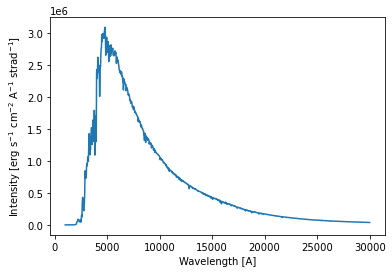

In [6]:
# By default, read_spectrum() returns the spectrum in full resolution, which is difficult to 
# visualize. The optional argument "num_bins" automatically folds the spectrum into the specified
# number of uniform wavelength bins, making it far more presentable
spectrum = atlas.read_spectrum(run_dir, num_bins = 1000)

# Plot the spectrum with MatPlotLib
plt.plot(spectrum['wl'], spectrum['flux'])
plt.xlabel('Wavelength [A]')
plt.ylabel('Intensity [erg s$^{-1}$ cm$^{-2}$ A$^{-1}$ strad$^{-1}$]')

Instead of binning the spectrum, one may choose to examine a particular feature up close at full resolution. For example, the cell below plots the sodium D doublet at $589$ nm:

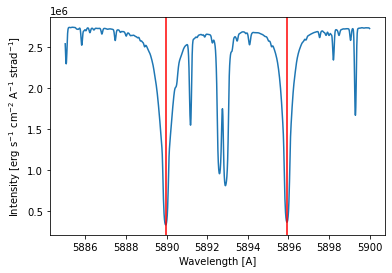

In [7]:
# No binning this time
spectrum = atlas.read_spectrum(run_dir)

# Range of wavelengths to plot
mask = (spectrum['wl'] > 5885) & (spectrum['wl'] < 5900)

# Plot the spectrum with MatPlotLib
plt.plot(spectrum['wl'][mask], spectrum['flux'][mask])
plt.xlabel('Wavelength [A]')
plt.ylabel('Intensity [erg s$^{-1}$ cm$^{-2}$ A$^{-1}$ strad$^{-1}$]')

# Mark line centres
plt.axvline(5889.95, color = 'r')
plt.axvline(5895.924, color = 'r')